# Imbalanced learn ⚖️

Koristićemo biblioteku za rad sa nebalansiranim klasama: [imblearn](https://imbalanced-learn.org/stable/).
U okviru ove sveske biće prikazane različite tehnike:
   * Oversampling
        - RandomOverSampler
        - SMOTE
   * UnderSampling
        - RandomUnderSampling
        - NearMiss
        - CondenseNearestNeighnour
   * Combination of over and under sampling
        - SMOTEENN
   * Imbalanced Ensamble
        - BalancedRandomForestClassifier

In [1]:
# instaliranje biblioteke
# !pip install imblearn

#### Imports

In [2]:
import imblearn as im
import pandas as pd
from imblearn.datasets import fetch_datasets

#### Skup podataka
Problem koji rešavamo je klasifikacija mase na _Benignu_ (-1) i _Malignu_ (1) na osnovu mamografskog rezultata. Skup podataka sa kojim ćemo raditi je _mammography_ koji je dostupan u okviru imblearn skupova.

In [3]:
mammography = fetch_datasets()['mammography']

In [4]:
X = pd.DataFrame(mammography.data)
Y = pd.Series(mammography.target)

#### Analiza skupa podataka

In [5]:
X.shape

(11183, 6)

#### Opisne statistike

In [6]:
X.describe()

,0,1,2,3,4,5
count,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04
mean,1.096536e-10,1.297595e-09,5.698113e-10,-2.435706e-09,-1.120680e-09,1.459483e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
25%,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
50%,-1.085769e-01,-3.949941e-01,-2.309790e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
75%,3.139489e-01,-7.649473e-02,2.198366e-01,8.202077e-01,-3.778657e-01,1.016613e+00
max,3.150844e+01,5.085849e+00,2.947777e+01,9.591164e+00,2.361712e+01,1.949027e+00


❔ Šta možemo zaključiti o podacima? (Standardizovani su)

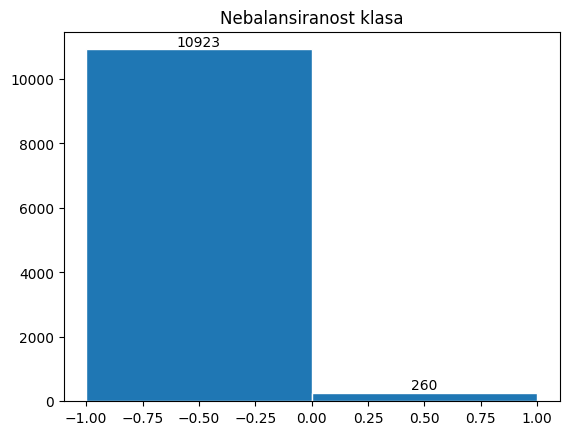

In [7]:
import numpy as np
from matplotlib import pyplot as plt

freq, bins, _ = plt.hist(Y, edgecolor='white', bins=2)

bin_centers = np.diff(bins)*0.5 + bins[:-1] # računanje centra korpice

for fr, x in zip(freq, bin_centers):
    height = int(fr)
    plt.annotate("{}".format(height),
               xy = (x, height),             # poziciranje broja iznad korpice
               xytext = (0,0.2),             # odvajanje teksta od korpice
               textcoords = "offset points", 
               ha = 'center', va = 'bottom'
               )
plt.title('Nebalansiranost klasa')

plt.show()

#### Podela na trening i test skup

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.25, random_state=42)

## Metrike za evaluaciju prilikom rada sa nebalansiranim klasama

U situacijama kada imamo jako nebalansirane klase, ne možemo da koristimo _accuracy_ za evaluaciju modela. Npr. ako 99% instanci 
koje pripadaju većinskoj klasi. Naš model može klasifikovati sve instance u većinsku (što bi bio jako loš model), ali bi _accuracy_ bila 0,99 (što bi signaliziralo da je model jako dobar).
Izveštaj klasifikacije za nebalansirane klase u okviru sklearn-a prikazuje state-of-the-art metrike, kao što su precision/recall/specificity, geometric mean, and index balanced accuracy of the geometric mean.
[Literatura za detaljnije upoznavanje sa navedenim metrikama.](https://imbalanced-learn.org/dev/references/generated/imblearn.metrics.classification_report_imbalanced.html)

#### Pomoćna funkcija za izveštaj klasifikacije

In [10]:
# !pip install termcolor
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from termcolor import colored

def report_imbalanced(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['B', 'M'], index=['B', 'M']))
    print("---------------------------------------------------------------------------------")

## Klasican nacin rada
Koristićemo stablo odlučivanja. 

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
model_dtc = DecisionTreeClassifier(max_depth=6, min_samples_split=50, criterion='gini')

In [13]:
model_dtc.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=50)

In [14]:
report_imbalanced(model_dtc, X_train, Y_train, "training")

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.50      0.99      0.71      0.53      8192
          1       0.91      0.50      1.00      0.65      0.71      0.48       195

avg / total       0.99      0.99      0.51      0.99      0.71      0.53      8387

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
      B   M
B  8182  10
M    97  98
---------------------------------------------------------------------------------


In [15]:
report_imbalanced(model_dtc, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.38      0.99      0.62      0.41      2731
          1       0.68      0.38      1.00      0.49      0.62      0.36        65

avg / total       0.98      0.98      0.40      0.98      0.62      0.41      2796

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
---------------------------------------------------------------------------------
      B   M
B  2719  12
M    40  25
---------------------------------------------------------------------------------


📚 Domaći: postaviti class_weight na "balanced". Da li se dobija bolji model?

## Tehnike rada sa nebalansiranim klasama

In [16]:
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled
    

In [17]:
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.5):
    """
        x_opacity - [0, 1] -> prozirnost elemenata klase (podešavati u odnosu na to da li prikazujemo samo 1 klasu ili obe)
    """
    
    #Da bismo vizuelizovali, iskoristicemo PCA da smanjimo na 2 dimenzije
    
    pca = PCA(n_components=2)
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled) 
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        colors = ['b' if y == -1 else 'r' for y in Y_stacked[i]]
        alpha = [x_opacity if y == -1 else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:, 0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title('{} resampling'.format("After" if i else "Before"), c = 'blue' if i else 'green')
    plt.show()

Nakon primene svake od tehnika rada sa nebalansiranim klasama, primenjujemo isti model.

📚 Domaći: Popraviti korišćeni model. Probati i sa ostalim modelima koje smo koristili na vezbama. Koji se pokazao kao najbolji za rešavanje ovog problema klasifikacije? 

In [18]:
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test):
    model = DecisionTreeClassifier(max_depth=7, min_samples_split=25, criterion='gini')
    model.fit(X_train, Y_train)
    report_imbalanced(model, X_train, Y_train)
    report_imbalanced(model, X_test, Y_test)
    return model

### Data leakage ☠️
Da li resampling vršimo pre ili posle podele na trening i test? Posle!! Zašto?

## Over-sampling

Jedan način borbe sa ovim problemom je generisanje novih instanci uzorkovanjem manjinske klase.

### RandomOverSampler
Naivna strategija je da generišemo nove instance slučajnim uzorkovanjem sa ponavljanjem iz postojećeg skupa podataka.
Uzorkovanje se vrši iz manjinske klase sa ponavljanjem.

In [19]:
from collections import Counter

In [20]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0, sampling_strategy='minority')

Number of instances before resampling with RandomOverSampler : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with RandomOverSampler : dict_items([(-1, 8192), (1, 8192)]). 


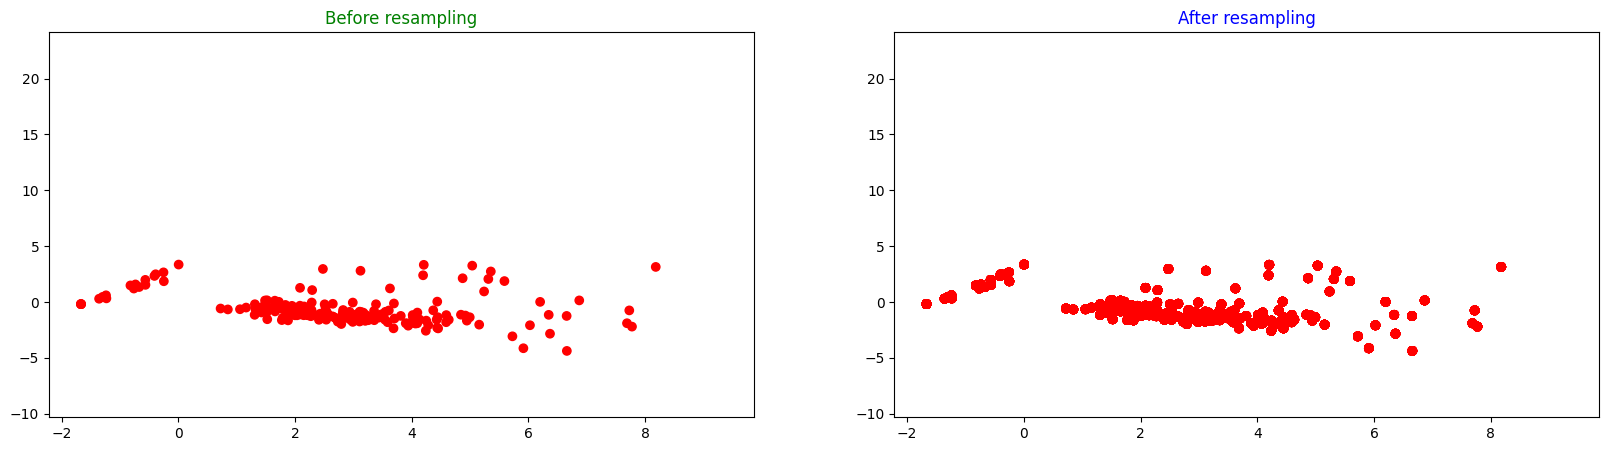

In [21]:
X_resampled, y_resampled = resample(ros, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 0)

Na slici iznad je vizuelizovana manjinska klasa pre i nekom uzorkovanja.

Na osnovu slike možemo da vidimo glavni nedostatak ove tehnike. Broj instanci u većinskoj klasi je 40 puta veći od broja instanci u manjinskoj. Kako vršimo slučajno uzorkovanje sa ponavljanjem, svaka od instanci će se ponoviti veći broj puta. Dakle, na ovaj način ne dobijamo nove informacije o manjinskoj klasi, već samo povećavamo njihov broj.

In [22]:
model_ros = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.94      0.97      0.93      0.95      0.95      0.91      8192
          1       0.97      0.93      0.97      0.95      0.95      0.90      8192

avg / total       0.95      0.95      0.95      0.95      0.95      0.91     16384

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
      B     M
B  7941   251
M   538  7654
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
 

### SMOTE -  Synthetic Minority Oversampling Technique

Dok RandomOverSampler vrši dupliranje originalnih uzoraka, SMOTE **generiše nove instance interpolacijom**.

Dodatna literatura: [originalni rad u kome je predložen SMOTE](https://arxiv.org/pdf/1106.1813.pdf).

#### Kratko objašnjenje SMOTE


Zamislimo da imamo narednu situaciju i želimo da primenimo SMOTE algoritam:

![](img/smote1.png)

SMOTE sintetiše nove instance između postojećih (originalnih) instanci manjinske klase. Možemo zamisliti kao povlačenje linija između postojećih instanci - kao na narednoj slici.

![](img/smote2.png)

Jedan od parametara koji je bitan za SMOTE algoritam je **k_neighbors**, koji označava koliko najbližih suseda razmatramo za svaku instancu manjinske klase.

Na primer, za **k_neighbors = 1**: 
![](img/smote3.png)

Dakle, posmatramo najbližeg suseda, i generišemo instancu na liniji između te dve tačke. 

Uopšteno, SMOTE iterira kroz postojeće instance originalnog skupa. U svakoj iteraciji, jedan od K najbližih suseda se izabere i sintetiše se nova instanca negde između originalne instance i izabranog suseda.

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=10, random_state=42)

Number of instances before resampling with SMOTE : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with SMOTE : dict_items([(-1, 8192), (1, 8192)]). 


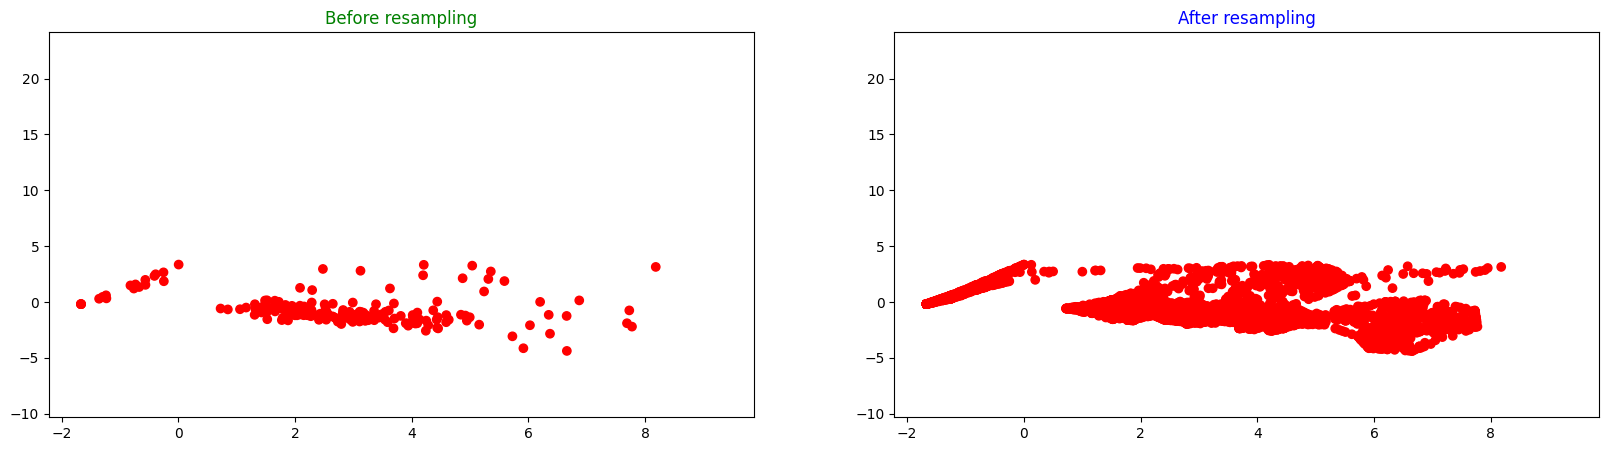

In [24]:
X_resampled, y_resampled = resample(smote, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 0)

Vidimo da je sada gušće popunjen prostor instancama. Dakle, dodali smo nove informacije o manjinskoj klasi, ali smo potencijalno uneli preveliki šum u naše podatke. 

❔ Da li je ova tehnika osetljiva na autlajere?

In [25]:
model_smote = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.95      0.96      0.95      0.95      0.95      0.91      8192
          1       0.96      0.95      0.96      0.95      0.95      0.91      8192

avg / total       0.95      0.95      0.95      0.95      0.95      0.91     16384

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
      B     M
B  7862   330
M   426  7766
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
 

## Under - sampling

Drugi način je da smanjimo broj instanci većinske klase - opet uzorkovanjem.

### Random under sampling
Naivna varijanta je da izvršimo slučajno uzorkovanje iz većinske klase. Analogno oversampling tehnici, samo se na slučajan način iz većinske klase biraju instance koje će biti izbačene.

In [26]:
from imblearn.under_sampling import RandomUnderSampler

In [27]:
rus = RandomUnderSampler()

Number of instances before resampling with RandomUnderSampler : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with RandomUnderSampler : dict_items([(-1, 195), (1, 195)]). 


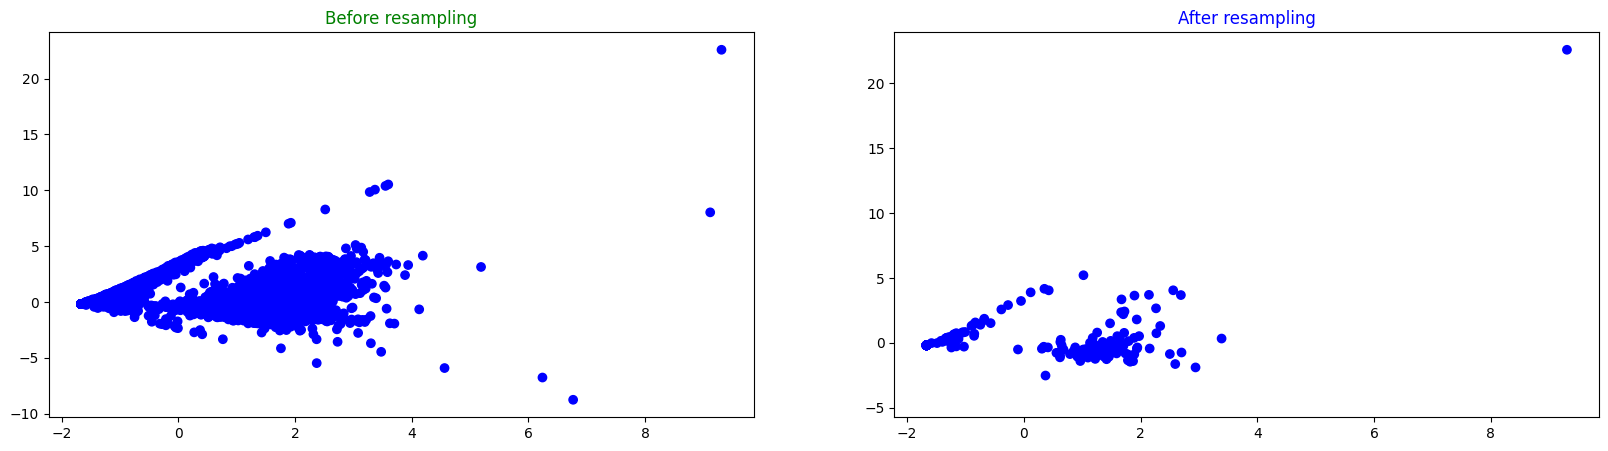

In [28]:
X_resampled, y_resampled = resample(rus, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 1)

Jednostavna tehnika, kojom smo izbalansirali klase, ali potencijalno izgubili bitne informacije o većinskoj klasi.

In [29]:
model_rus = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.86      0.91      0.86      0.89      0.88      0.79       195
          1       0.91      0.86      0.91      0.88      0.88      0.78       195

avg / total       0.89      0.88      0.88      0.88      0.88      0.78       390

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
     B    M
B  178   17
M   28  167
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
       

## NearMiss - version 1 2 3

The Near-Miss algoritam posmatra instance i njihove susede i na osnovu klasa vrši under sampling. 

NearMiss-1 bira instance većinske klase koje imaju najmanje srednje rastojanje od _K_ **najbližih** instanci manjinske klase.  

In [30]:
from imblearn.under_sampling import NearMiss

Number of instances before resampling with NearMiss : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with NearMiss : dict_items([(-1, 195), (1, 195)]). 


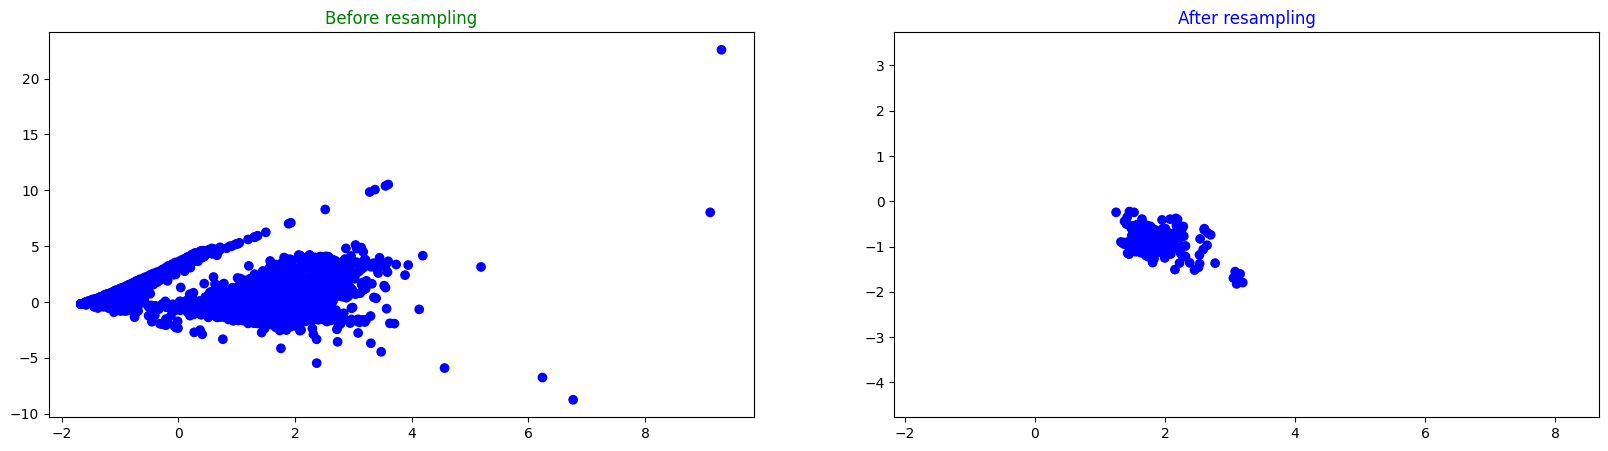

In [31]:
nm1 = NearMiss(version=1, n_neighbors=20)
X_resampled, y_resampled = resample(nm1, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 1)

In [32]:
model_nm1 = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.84      0.97      0.82      0.90      0.89      0.81       195
          1       0.96      0.82      0.97      0.89      0.89      0.78       195

avg / total       0.90      0.89      0.89      0.89      0.89      0.80       390

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
     B    M
B  189    6
M   35  160
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
       

NearMiss-2 bira instance većinske klase koje imaju najmanje srednje rastojanje od _K_ **najdaljih** instanci manjinske klase.  

Number of instances before resampling with NearMiss : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with NearMiss : dict_items([(-1, 195), (1, 195)]). 


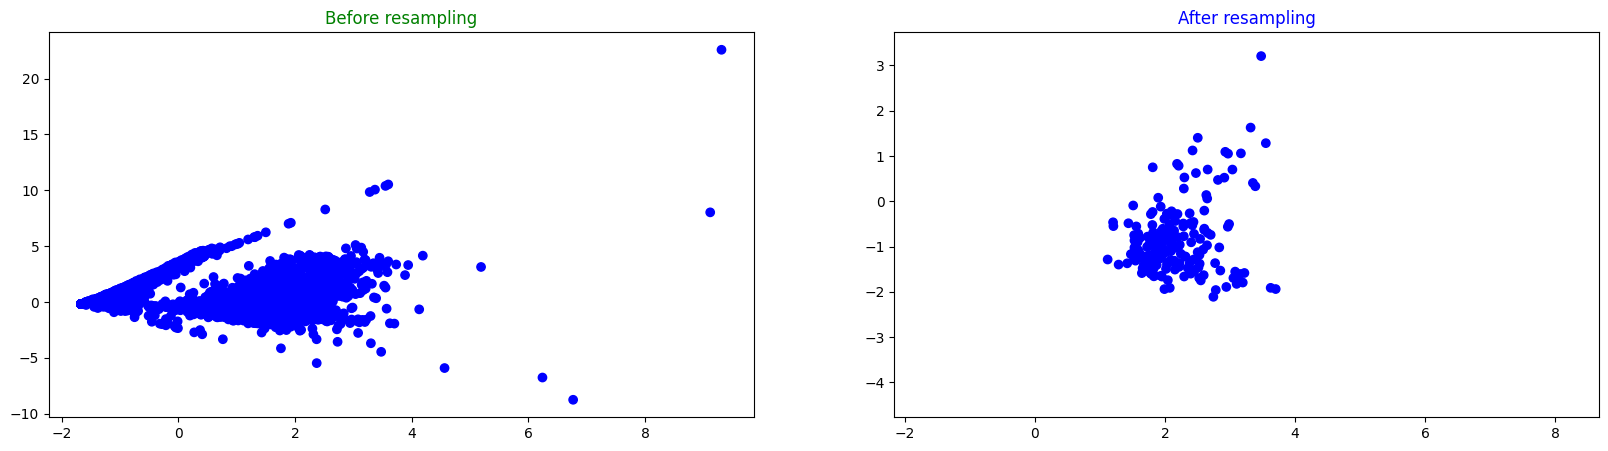

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.89      0.98      0.88      0.94      0.93      0.88       195
          1       0.98      0.88      0.98      0.93      0.93      0.86       195

avg / total       0.94      0.93      0.93      0.93      0.93      0.87       390

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
     B    M
B  192    3
M   23  172
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
       

In [33]:
nm2 = NearMiss(version=2, n_neighbors=20)
X_resampled, y_resampled = resample(nm2, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 1)
model_nm2 = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

NearMiss-3 algoritam se sastoji od 2 koraka. 
Prvo, za svaku instancu manjinske klase se čuva _K_ najbliži sused. 
Zatim se biraju instance većinske klase za koje je usrednjeno rastojanje od _K_ najbližih suseda **najveće**.

Number of instances before resampling with NearMiss : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with NearMiss : dict_items([(-1, 195), (1, 195)]). 


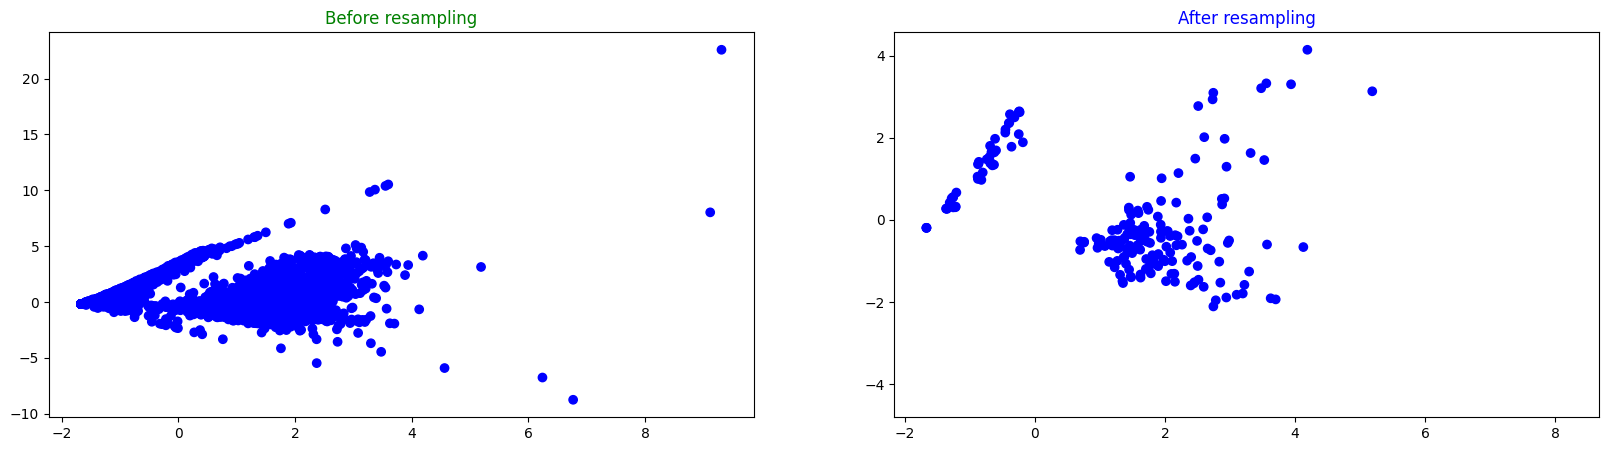

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.81      0.85      0.80      0.83      0.82      0.68       195
          1       0.84      0.80      0.85      0.82      0.82      0.67       195

avg / total       0.82      0.82      0.82      0.82      0.82      0.68       390

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
     B    M
B  165   30
M   39  156
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
       

In [34]:
nm3 = NearMiss(version=3, n_neighbors=20)
X_resampled, y_resampled = resample(nm3, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 1)

model_nm3 = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Predstavljaju jedne od najboljih under-sample tehnika.
Sve tri verzije su osetljive na šum, od čega je NearMiss-1 najosetljiviji, a NearMiss-3 najmanje.

### CondenseNearestNeighbour

CondensedNearestNeighbour koristi 1-najbliži-sused pravilo da iterativno odluči koje instance iz većinske klase treba ukloniti. 

Koraci:

1. Ubaciti sve instance iz manjinske klase u skup _C_.

2. Dodati uzorak iz većinske klase u _C_ i sve ostale uzorke u skup _S_.

3. Iterirati kroz S, uzorak po uzorak i klasifikovati svaki na osnovu pravila 1-suseda.
4. Ako je uzorak netačno klasifikovan, ubaciti ga u _C_.
5. Ponavljati postupak sve dok postoje inastance koje se mogu dodati.


CondensedNearestNeighbour je osetljiv na šum i dodaje šum u podatke.

Number of instances before resampling with CondensedNearestNeighbour : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with CondensedNearestNeighbour : dict_items([(-1, 193), (1, 195)]). 


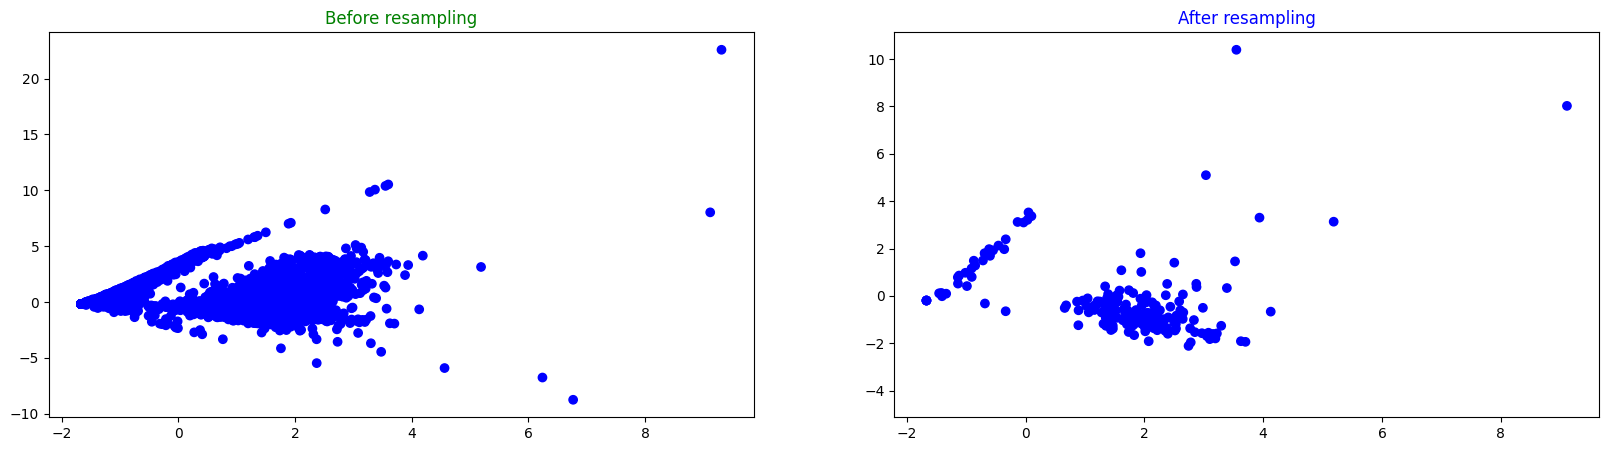

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.86      0.81      0.87      0.83      0.84      0.70       193
          1       0.82      0.87      0.81      0.84      0.84      0.70       195

avg / total       0.84      0.84      0.84      0.84      0.84      0.70       388

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
     B    M
B  156   37
M   26  169
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
       

In [35]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=0, n_neighbors=10, sampling_strategy='majority')
X_resampled, y_resampled = resample(cnn, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 1)
model_cnn = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

## Combination of over and under sampling - SMOTEENN

Prethodno smo prikazali SMOTE algoritam, kao over-sampling tehniku, koja unosi šum u podatke interpolacijom novih tačaka između marginalnih outlajera i inlajnera. Ovaj problem se rešava čišćenjem podataka dobijenih over-sampling tehnikom.

Edited nearest-neighbours predstavlja metodu čišćenja podataka nakon primene SMOTE algoritma (under-samping tehnika).

ENN metoda pronalazi K najbližih suseda za svaku instancu i preverava da li je većinska klasa k najbližih instanci ista kao i klasa posmatrane instance. Ukoliko nije, posmatrana instanca i susedi se uklanjaju iz skupa. Najčešće vrednost je K = 3.

[Literatura za ENN metod čišćenja podataka nakon primene oversampling tehnika.](https://www.inf.ufrgs.br/maslab/pergamus/pubs/balancing-training-data-for.pdf)

Number of instances before resampling with SMOTEENN : dict_items([(-1, 8192), (1, 195)]). 
Number of instances after  resampling with SMOTEENN : dict_items([(-1, 7722), (1, 7926)]). 


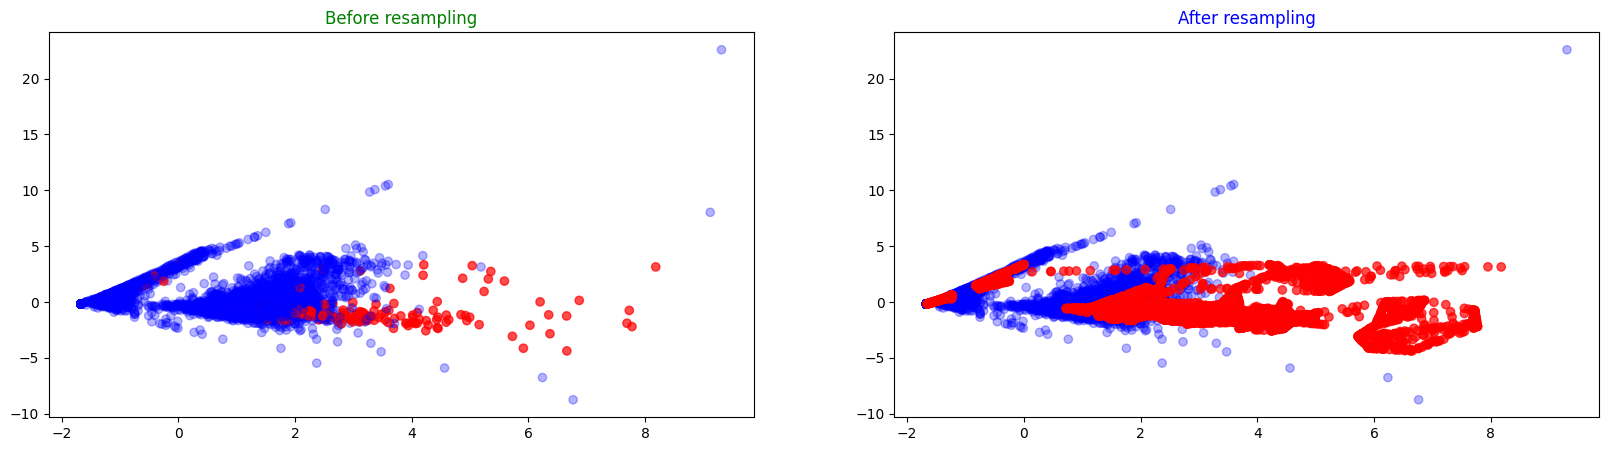

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.98      0.98      0.98      0.96      7722
          1       0.98      0.98      0.98      0.98      0.98      0.96      7926

avg / total       0.98      0.98      0.98      0.98      0.98      0.96     15648

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
      B     M
B  7574   148
M   187  7739
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
 

In [36]:
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier
smoteenn = SMOTEENN(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = resample(smoteenn, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 0.3)
model_smoteenn = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

## Ensamble methods

Pošto smo se već upoznali sa ansamblima kao primerom efikasnih modela, oni se mogu pronaći i u okviru imblearn biblioteke.

Balansirane slučajne šume vrše slučajan under-sampling svakog uzorka koji se koristi za formiranje slučajne šume.

In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier

model_ens = BalancedRandomForestClassifier(max_depth=6, random_state=42, max_samples=20)

In [38]:
model_ens.fit(X_train, Y_train)

C:\Users\Nemanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Nemanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Nemanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original pape

BalancedRandomForestClassifier(max_depth=6, max_samples=20, random_state=42)

In [39]:
report_imbalanced(model_ens, X_train, Y_train)
report_imbalanced(model_ens, X_test, Y_test)

Classification report for model BalancedRandomForestClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.89      0.87      0.94      0.88      0.77      8192
          1       0.16      0.87      0.89      0.27      0.88      0.77       195

avg / total       0.98      0.89      0.87      0.92      0.88      0.77      8387

---------------------------------------------------------------------------------
Confusion matrix for model BalancedRandomForestClassifier on training data 
---------------------------------------------------------------------------------
      B    M
B  7288  904
M    26  169
---------------------------------------------------------------------------------
Classification report for model BalancedRandomForestClassifier on training data
--------------------------------------------------------------

### Poređenje modela - ROC ili PR kriva

Na slici se nalazi matrica konfuzije.

![confusion-matrix.png](img/confusion-matrix.png)

$Precision = \frac{TP}{TP+FP}$ - broj true positive kroz ukupan broj _dodeljenih_ pozitivnih.

$Recall = \frac{TP}{TP+FN}$ - broj true positive kroz ukupan broj _pravih_ pozitivnih (True positive rate). 

Napomena: Kada je u pitanju binarna klasifikacija recall se naziva i _sensitivity_.

#### PR kriva

Precision-Recall kriva prikazuje odnos između ove dve mere.

Precision sadrži informaciju koliko pozitivnih instanci smo uspeli da ispravno klasifikujemo.
Recall nam daje informaciju od svih zaista pozitivnih instanci, koliko smo ih ispravno klasifikovali.

Jasno nam je da sa rastom jedne od ovih mera, druga opada. Na primer, Ako bismo sve instance klasifikovali u TRUE klasu, naš recall bi bio 1 (sve instance čija je prava klasa TRUE su klasifikovane kao TRUE (FN = 0), ali bi precision bio jako mali (jer bi FP bio veliki). 

Dakle, želimo da napravimo odgovarajući balans između ovih mera (zavisi od problema koji se rešava).

##### Pomoćna funkcija za prikaz PR krive

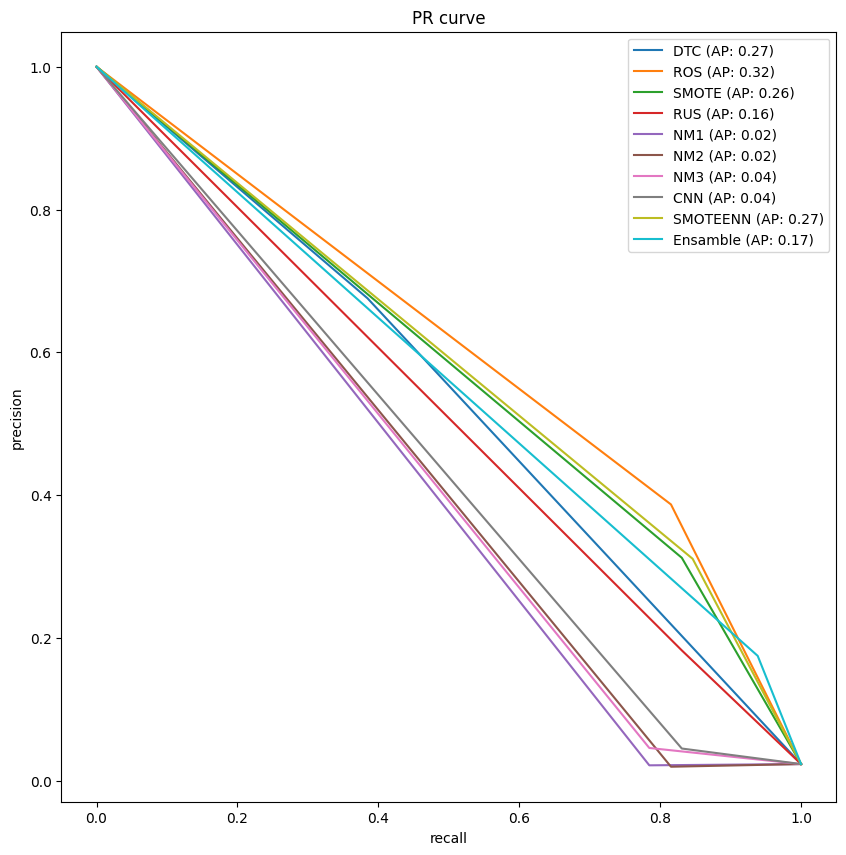

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
models = [model_dtc, model_ros, model_smote, model_rus, model_nm1, model_nm2, model_nm3, model_cnn, model_smoteenn, model_ens]
model_names = ['DTC', 'ROS', 'SMOTE', 'RUS', "NM1", "NM2", "NM3", "CNN", "SMOTEENN", "Ensamble"]

plt.figure(figsize=(10, 10))
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(Y_test, model.predict(X_test))
    ap = average_precision_score(Y_test, model.predict(X_test))
    lab = model_name + " (AP: " + str(round(ap, 2)) + ")"
    plt.plot(recall, precision, label=lab)


plt.xlabel('recall')
plt.ylabel('precision')

plt.title("PR curve")
plt.legend()
plt.show()

Ostalo name je još da prodiskutujemo kako da zaključimo koji model je najbolji, posmatrajući PR krivu.
Težimo tome da nam i precision i recall budu što veći.
Dakle, preferiramo krive koje su što bliže gornjem desnom uglu.

Način na koji možemo da evaluiramo modele je korišćenjem [_average precision score (AP)_.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html)
Što je AP veći to je model bolji.

#### ROC kriva

A receiver operating characteristic curve (ROC curve) prikazuje odnos između TPR(recall) i FPR.

$TPR = \frac{TP}{TP+FN}$

$FPR = \frac{FP}{FP+TN}$ - intuitivno, šansa da smo naš uzorak "zarazili" sa FP instancama.



#### Pomoćna funkcija za prikac ROC krive

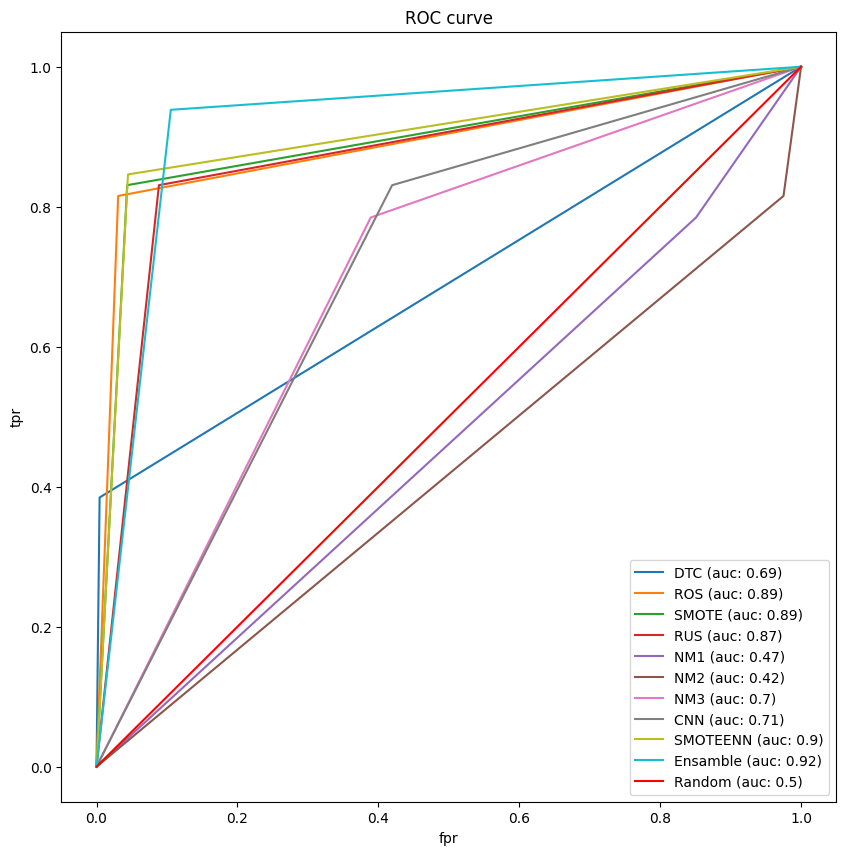

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [model_dtc, model_ros, model_smote, model_rus, model_nm1, model_nm2, model_nm3, model_cnn, model_smoteenn, model_ens]
model_names = ['DTC', 'ROS', 'SMOTE', 'RUS', "NM1", "NM2", "NM3", "CNN", "SMOTEENN", "Ensamble"]

plt.figure(figsize=(10, 10))

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + " (auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("ROC curve")
plt.legend()
plt.show()

Kada posmatramo ROC krivu, model je bolji što je kriva bliža gornjem levom uglu (što veći TPR, a što manji FPR).
Za evaluciju koristimo [_area under the curve (AUC)_](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html). Što je AUC bliži 1, to je model bolji.

#### ROC vs PR

Na prvi pogled nam se krive čine jako slične. 

Neka je $Y$ prava klasa kojoj pripada instanca,
a $\hat{Y}$ klasa koju model dodeli instanci (predviđena klasa).
$P(X|Y)$ - uslovna verovatnoća za događaj $X$ ako se desio događaj $Y$.

Za prikaz PR i ROC krive koristili smo 3 informacije.
Za PR - precision i recall,
a za ROC - fpr i recall. 

 Formalno: 
 
 * $Precision = P(Y = 1 | \hat{Y} = 1)$
 * $Recall/TPR = P(\hat{Y} = 1 | Y = 1)$
 * $FPR = P(\hat{Y} = 1 | Y = 0 )$

Bitno je da primetimo da je uslov kod precision predviđena klasa, dok je kod recall i fpr uslov prava klasa.

Ova osobina može imate veliki uticaj na evaluaciju ukoliko radimo sa nebalansiranim klasama ili ako veći značaj dajemo TP nego FN. 

#### Primer 
Posmatramo skup pacijenata i vršimo klasifikaciju karcinoma (100000 - negativnih i 100 pozitivnih instanci).
Imamo dva klasifikaciona modela A i B.

Nakon pokretanja oba klasifikatora, oba su ispravno klasifikovala 99/100 pacijenata. Matrice konfuzije se nalaze u nastavku.

**Matrica konfuzije za model A**

|             | real T      | real F      |
|-----------  | ----------- | ----------- |           
|predicted T  | 99     | 51       |
|predicted F  | 1   |     9949    |



**Matrica konfuzije za model A**
|             | real T      | real F      |
|-----------  | ----------- | ----------- |
|predicted T  | 99     | 901       |
|predicted F  |1   | 9099      |


Recall za oba modela je isti -> **0.99**

FPR za modele:

FPR_A = 51/(51 + 10000) = 0.0005

FPR_B = 901/(901 + 10000) = 0.008

Ako bismo koristili ROC krivu, oba modela bi imala zanemarljive razlike i jednako dobre performanse (isti recall i skoro iste fpr).

Ali, ako bismo koristili PR krivu:

Precision_A = 99 / (99+51) = 0.66

Precision_B = 99 / (99 + 901) = 0.099

Dakle, ukoliko bismo koristili PR krivu za poređenje, sada vidimo veliku razliku! Model A ima preciznost 0.66, dok B ima < 0.1!



**Zaključak: Ako radimo sa nebalansiranim klasama, ROC kriva može dati previše optimistične evaluacije.**

Takođe, na osnovu naših modela, na grafičkim prikazima PR i ROC se može videti problem sa radom sa ROC krivom.

Na primer, AUC za BalnacedRandomForestClassifier je 0,92 (jako dobar model), ali je AP 0,17. 

####  📚 Diskusija i domaći

Posmatrajući ROC krivu imamo utisak da smo istrenirali nekoliko solidnih modela, ali PR kriva pokazuje da zapravno nijedan nije preterano dobar.

Do ovog zaključka smo mogli da dođemo i na osnovu analize matrica konfuzije. Svi modeli imaju veliki broj FP instanci (nisku preciznost).

❔ Da li je kod nekih modela došlo do preprilagođavanja?

❔ Popraviti modele, tako da daju bolje rezultate. 

### Bitna napomena za kraj

❗❗ U okviru ovih materijala, fokus je na tehnikama rada sa nebalansiranim klasama. Iz tog razloga je korišćen identičan model za klasifikaciju. Naravno, pri realnoj primeni, ne postoji osnova za korišćenje identičnog modela, sa identičnim hiper-parametrima, s obzirom na to da različite tehnike daju različite rezultate (skupove podataka), pa bi i odbir modela i hiper-parametara trebalo da se vrši shodno ovim razlikama.